# Feature selection with decision trees

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline as ImbPipeline

import optuna
from sklearn.tree import DecisionTreeClassifier

from settings import OVER, UNDER, FEAT_SEL_PRE
from constants import FEATURES
from functions import importance_experiment

from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice


# Data Loading

In [2]:
X_train = pd.read_parquet("../../../../../data/interim/copper/X_train.parquet")
y_train = pd.read_parquet("../../../../../data/interim/copper/y_train_cat.parquet")

bootstrap = lambda X, i: X.sample(X.shape[0], replace=True, random_state=i)

X_list = [bootstrap(X_train[FEATURES], i) for i in range(1, 101, 10)]
y_list = [y_train.loc[X.index] for X in X_list]

# Optimization

In [5]:
study = optuna.load_study(
    study_name="decision_feat_sel",
    storage='sqlite:///decision_feat_sel.db',
)

params = study.best_params
params["criterion"] = "entropy"
params["class_weight"] = "balanced"

# Feature Selection

## Feature importance calculation

In [6]:
steps_list = [
    ('preprocessor', FEAT_SEL_PRE),
    ('over', OVER),
    ('under', UNDER),
    ('classifier', DecisionTreeClassifier(**params))]
    
pipe = ImbPipeline(steps_list)

pipe.fit(X_train, y_train)
NEW_FEATURES = pipe[:-1].get_feature_names_out()
NEW_FEATURES = [col.split("__")[1] for col in NEW_FEATURES]

pipe = ImbPipeline(steps_list)

In [7]:
experiments = importance_experiment(X_list, y_list, pipe)

## Feature Importance Vizualization

In [8]:
exp_dfs = []

for exp in experiments:
    exp_dfs.append(pd.DataFrame([exp.tolist()], columns=NEW_FEATURES).reset_index())

exp_df = pd.concat(exp_dfs)
exp_df.reset_index(drop=True, inplace=True)


In [9]:
exp_median_df = exp_df.groupby("index").median()

plot_df = (
    exp_median_df.T
    .reset_index()
    .rename(columns={"index": "feature"})
    .melt(id_vars="feature", var_name="experiment", value_name="importance")
)

order = (
    plot_df
    .groupby("feature")["importance"]
    .mean()
    .sort_values(ascending = False).index
)

<Axes: xlabel='importance', ylabel='feature'>

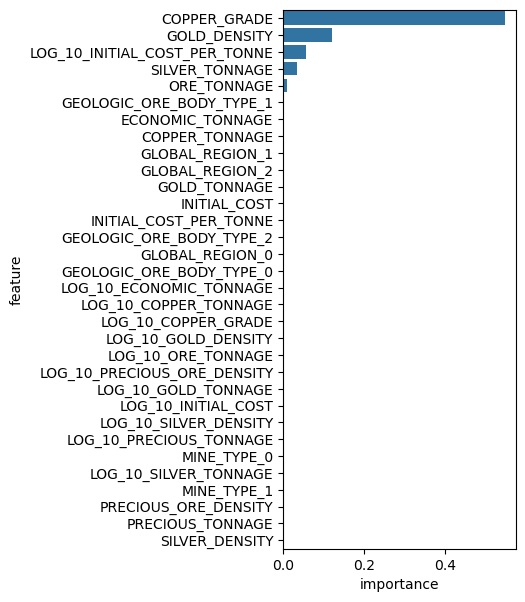

In [41]:
plt.figure(figsize=(3, 7))
sns.barplot(plot_df, y = "feature", x = "importance", orient="h", order=order)

In [42]:
order

Index(['COPPER_GRADE', 'GOLD_DENSITY', 'LOG_10_INITIAL_COST_PER_TONNE',
       'SILVER_TONNAGE', 'ORE_TONNAGE', 'GEOLOGIC_ORE_BODY_TYPE_1',
       'ECONOMIC_TONNAGE', 'COPPER_TONNAGE', 'GLOBAL_REGION_1',
       'GLOBAL_REGION_2', 'GOLD_TONNAGE', 'INITIAL_COST',
       'INITIAL_COST_PER_TONNE', 'GEOLOGIC_ORE_BODY_TYPE_2', 'GLOBAL_REGION_0',
       'GEOLOGIC_ORE_BODY_TYPE_0', 'LOG_10_ECONOMIC_TONNAGE',
       'LOG_10_COPPER_TONNAGE', 'LOG_10_COPPER_GRADE', 'LOG_10_GOLD_DENSITY',
       'LOG_10_ORE_TONNAGE', 'LOG_10_PRECIOUS_ORE_DENSITY',
       'LOG_10_GOLD_TONNAGE', 'LOG_10_INITIAL_COST', 'LOG_10_SILVER_DENSITY',
       'LOG_10_PRECIOUS_TONNAGE', 'MINE_TYPE_0', 'LOG_10_SILVER_TONNAGE',
       'MINE_TYPE_1', 'PRECIOUS_ORE_DENSITY', 'PRECIOUS_TONNAGE',
       'SILVER_DENSITY'],
      dtype='object', name='feature')